In [5]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("obsSSRG_nadir.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwc_CS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]
    
pnorm=np.log10(1e-3*(pnorm+1e-9))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)*0.5
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(zKu)
zKuPC=pca.transform(zKu)
print(zKuPC.shape)
#stop
bscatter=pnorm[:,30:45]
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    z1[z1<8]=0
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
yobsLidarLR=yobsL
yobsLidarL=yobsL
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape
X_train=yobsL[ind_train,:]
X_test=yobsL[ind_test,:]
XLidar_train=yobsLidarL[ind_train,:]
XLidar_test=yobsLidarL[ind_test,:]
XLidarR_train=yobsLidarLR[ind_train,:]
XLidarR_test=yobsLidarLR[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]
iwc_CS_test=iwc_CS[ind_test,:]
zKu_train=zKu[ind_train,:]
zKu_test=zKu[ind_test,:]



/Users/mgrecu/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


(138606, 5)


In [83]:
print(XLidar_train.shape)

(92866, 21)


In [6]:
nC=18
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

#define tensorflow classifier in keras. use 2 hidden layers and nc=12 output classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import utils

# define the model
X1_train=XLidarR_train[:,:]
X1_test=XLidarR_test[:,:]

# import scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X1_train_scaled=scaler.transform(X1_train)
X1_test_scaled=scaler.transform(X1_test)

kmeans_X=MiniBatchKMeans(n_clusters=nC, random_state=0).fit(X1_train_scaled)


In [7]:
iwpC=[]
kgainL=[]
nx=X1_train_scaled.shape[1]
xmL=[]
iwc_means=[]
for i in range(nC):
    iwpC.append(kmeans_X.cluster_centers_[i,:].sum()*0.24)
    a=np.nonzero(kmeans_X.labels_==i)
    xk=X1_train_scaled[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.05*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.inv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xmL.append(np.mean(xk,axis=0))
    iwc_means.append(yk.mean(axis=0))

print(iwpC)

[1.1607885599861896, -0.15819744465898558, -1.0424603818329772, 0.6267048106915867, -0.26363903653987264, -0.7714381304166464, 0.01779257563310754, 0.03191933636798765, 0.29029355857828565, 0.6779228313515707, 0.5151582187951576, 1.041578087515076, -0.9328791086908617, -0.06143148516588669, -0.4972194588245652, -0.638638426834022, -0.2428963367744593, -1.4295682559554197]


In [33]:
print(covXY.shape)
print(kgainL[0].shape)

(156, 156)
(50, 106)


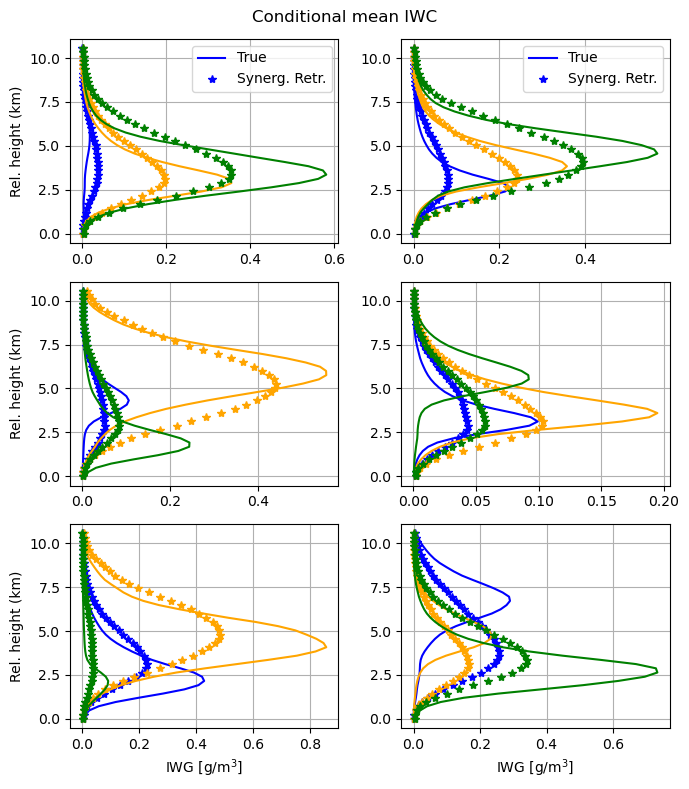

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_X_=kmeans_X.predict(X1_test_scaled)
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)
iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))
neigh = KNeighborsRegressor(n_neighbors=30,weights='distance')
neigh.fit(X1_train_scaled, iwc_train.sum(axis=1)*0.24)
iwp_test_neigh=neigh.predict(X1_test_scaled)
iclass=0
cols=['b','orange','g']


iwcLR_=[]
for i,iwp1_ in enumerate(X1_test_scaled):
    iclass=iwc_X_[i]
    iwc1=iwc_means[iclass]+0.975*np.dot(kgainL[iclass],X1_test_scaled[i,:]-xmL[iclass])
    iwcLR_.append(iwc1/iwc1.sum()/0.24*iwp_test_neigh[i])
iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Synerg. Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('iwcRetrievedKMeansClassesSSRG_Radiometer.png')

312.1483114525631 311.900268377211


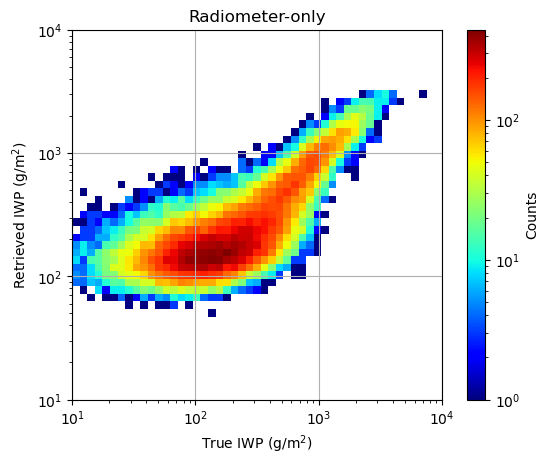

In [29]:


iwcLR_=np.array(iwcLR_)
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)
#plt.figure(figsize=(6,6))
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwp_test_neigh*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radiometer-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('radiometer_iwpRetrieval_nadir.png')

print(iwp_test_.mean()*1000,iwpLR_.mean()*1000)

(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_628/2581858766.py:15: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.         0.21514668]
 [0.21514668 1.        ]]


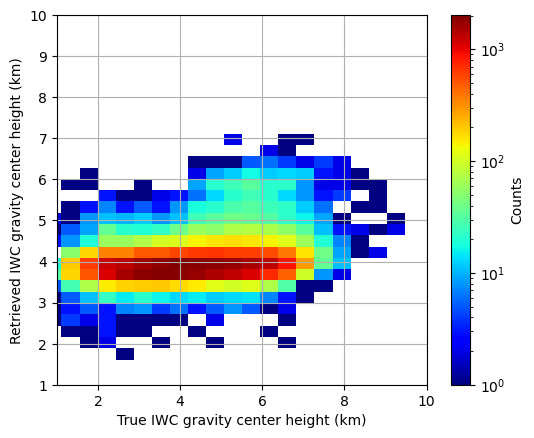

In [32]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    #hc1=(iwc1*np.arange(50)).sum()*0.24/iwc1.sum()
    #hc2=(iwc_test[i,:]*np.arange(50)).sum()*0.24/iwc_test[i,:].sum()
    a1=np.nonzero(iwc1>0.01)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    h=np.arange(50)
    if len(a1[0])>3:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    #print(hc1,hc2)
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=20,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
cbar.set_label('Counts')
plt.savefig('radiometerOnly_iwcGcHeight.png')
print(np.corrcoef(hgRealL,hgPredL))

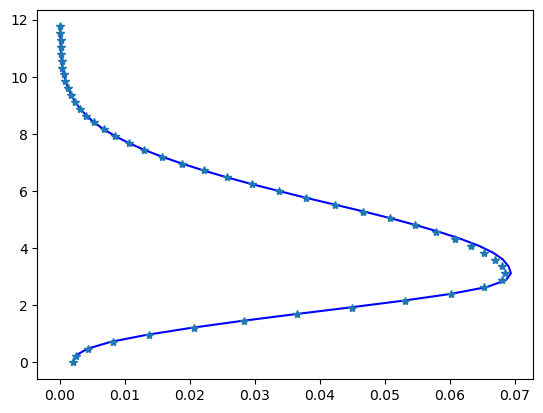

In [54]:
plt.plot(iwc_test.mean(axis=0),np.arange(0,50)*0.24,'b',label='True')
plt.plot(iwcLR_.mean(axis=0),np.arange(0,50)*0.24,'*',label='Retrieved')

In [18]:
print(iwc_.shape)

(92866, 50)
